In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
df = pd.read_csv("/content/online_retail__compass_9_11.csv")
df.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [133]:
df_dedup = pd.read_csv("/content/online_retail__compass_9_11.csv")

#Feature Engineering - Adding TotalSales and IsCancelled columns and taking non-negative Price.
df_dedup['TotalSales'] = df_dedup['Quantity'] * df_dedup['Price']
df_dedup['IsCancelled'] = df_dedup['Invoice'].astype(str).str.startswith('C')
df_dedup = df_dedup[df_dedup['Price'] > 0].copy()

#remove duplicate from data
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

df.drop_duplicates(inplace=True)
print(f"DataFrame size after dropping duplicates: {len(df)}")


Number of duplicate rows: 0
DataFrame size after dropping duplicates: 1067371


In [134]:
import pandas as pd
import numpy as np
from scipy import stats

#data transformation for invoice date to convert into date time
df_dedup['InvoiceDate'] = pd.to_datetime(df_dedup['InvoiceDate'],
                                        format='mixed',
                                        dayfirst=True,
                                        errors='coerce')

print(f"Initial row count after duplicates removed: {len(df_dedup)}")

# 1. Outlier Identification using Z-Score
df_dedup['TotalSales_ZScore'] = np.abs(stats.zscore(df_dedup['TotalSales']))
df_dedup['Quantity_ZScore'] = np.abs(stats.zscore(df_dedup['Quantity']))

# 2. Remove extreme outliers with z-score less than 3 from quatity or totalsales.
df_clean_stats = df_dedup[
    (df_dedup['TotalSales_ZScore'] <= 3) &
    (df_dedup['Quantity_ZScore'] <= 3)
].copy()

#checking impact of outliers by comparing datasets
outliers_removed = len(df_dedup) - len(df_clean_stats)
print(f"Number of extreme outliers removed (Z-Score > 3 in TotalSales or Quantity): {outliers_removed}")
print(f"Row count of the clean statistical dataset: {len(df_clean_stats)}")

df_dedup.drop(columns=['TotalSales_ZScore', 'Quantity_ZScore'], inplace=True)
df_clean_stats.drop(columns=['TotalSales_ZScore', 'Quantity_ZScore'], inplace=True)
df_clean_stats.to_csv("online_retail_clean_stats.csv", index=False)

Initial row count after duplicates removed: 1061164
Number of extreme outliers removed (Z-Score > 3 in TotalSales or Quantity): 1894
Row count of the clean statistical dataset: 1059270


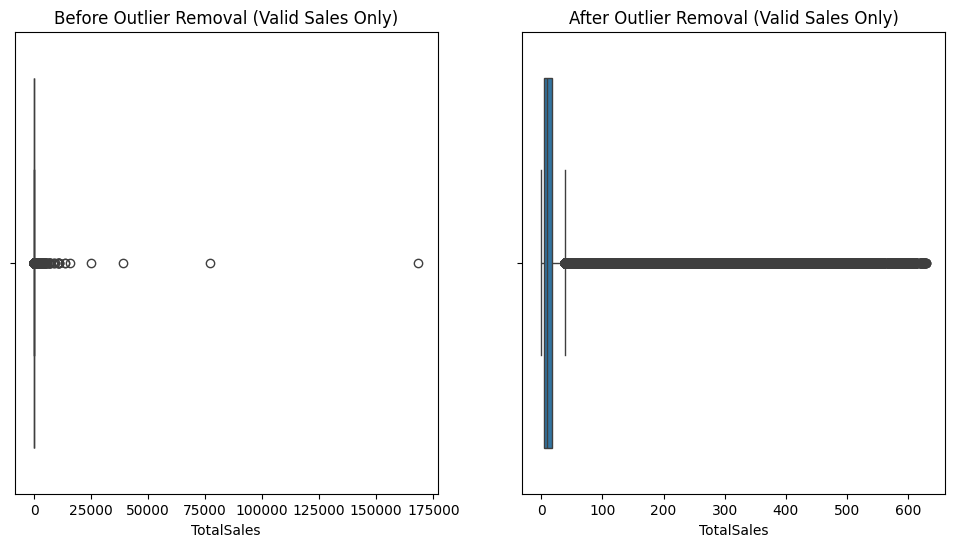

In [135]:
# Filter only positive, non-cancelled sales
df_valid_sales = df_dedup[(df_dedup['IsCancelled'] == False) & (df_dedup['TotalSales'] > 0)]

# Remove outliers
df_valid_sales['ZScore'] = np.abs(stats.zscore(df_valid_sales['TotalSales']))
df_valid_sales_no_outliers = df_valid_sales[df_valid_sales['ZScore'] <= 3]
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.boxplot(x=df_valid_sales['TotalSales'])
plt.title('Before Outlier Removal (Valid Sales Only)')

plt.subplot(1,2,2)
sns.boxplot(x=df_valid_sales_no_outliers['TotalSales'])
plt.title('After Outlier Removal (Valid Sales Only)')

plt.show()


--- Summary Statistics (After Outlier Removal) ---
|            | mean   | median   | std   | var     | skew   |
|:-----------|:-------|:---------|:------|:--------|:-------|
| Quantity   | 9.17   | 3.00     | 23.29 | 542.25  | 8.36   |
| Price      | 3.82   | 2.10     | 13.49 | 182.04  | 35.33  |
| TotalSales | 17.21  | 9.90     | 39.59 | 1567.32 | 7.30   |

--- Correlation Matrix (After Outlier Removal) ---
|            | Quantity   | Price   | TotalSales   |
|:-----------|:-----------|:--------|:-------------|
| Quantity   | 1.00       | -0.06   | 0.64         |
| Price      | -0.06      | 1.00    | 0.15         |
| TotalSales | 0.64       | 0.15    | 1.00         |


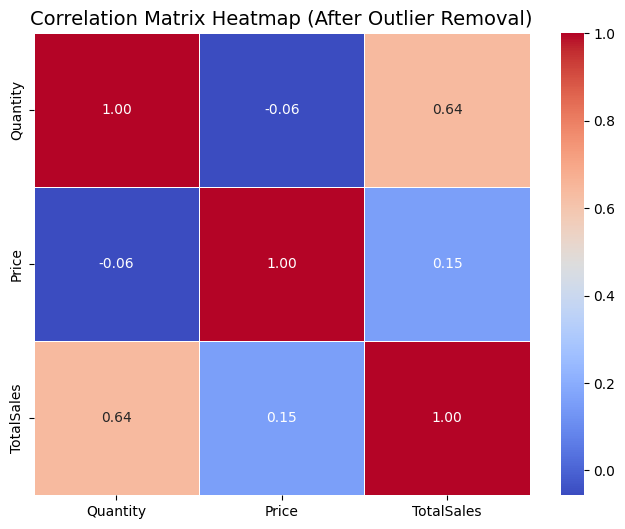

In [136]:
#basic stats on clean dataset
df_stats = pd.read_csv("online_retail_clean_stats.csv")
num_cols = ['Quantity', 'Price', 'TotalSales']

# 1. Compute Summary Statistics
summary_df = df_stats[num_cols].agg(
    ['mean', 'median', 'std', 'var', 'skew']
).T

print("\n--- Summary Statistics (After Outlier Removal) ---")
print(summary_df.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

# 2. Compute Correlation Matrix
corr_matrix = df_stats[num_cols].corr()

print("\n--- Correlation Matrix (After Outlier Removal) ---")
print(corr_matrix.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar=True          )
plt.title("Correlation Matrix Heatmap (After Outlier Removal)", fontsize=14)
plt.show()

In [137]:
from sklearn.preprocessing import StandardScaler

#dataset for modeling ready features
df_model = df_stats.copy()

# 1. Log Transformation on positive value
df_model['Log_TotalSales'] = np.log(df_model['TotalSales'])
df_model['Log_Price'] = np.log(df_model['Price'])
df_model['Log_Quantity'] = np.log(df_model['Quantity'])

# 2. Standardization scaling
feat_to_scale = ['Quantity', 'Price', 'TotalSales']
scaler = StandardScaler()
df_model[feat_to_scale] = scaler.fit_transform(df_model[feat_to_scale])

print("\n--- Standardized and Log-Transformed Features (Snippet) ---")
print(df_model[['Log_TotalSales', 'TotalSales', 'Price']].head().to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

#data used for modeling
df_model.to_csv("online_retail_model_ready.csv", index=False)


--- Standardized and Log-Transformed Features (Snippet) ---
|    | Log_TotalSales   | TotalSales   | Price   |
|:---|:-----------------|:-------------|:--------|
| 0  | 2.73             | -0.05        | -0.09   |
| 1  | 3.01             | 0.08         | -0.03   |
| 2  | 3.09             | 0.12         | -0.08   |
| 3  | 3.01             | 0.08         | -0.03   |
| 4  | 3.01             | 0.08         | -0.03   |


In [138]:
df_model.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales,IsCancelled,Log_TotalSales,Log_Price,Log_Quantity
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.136177,2010-12-01 08:26:00,-0.094405,17850.0,United Kingdom,-0.048204,False,2.727853,0.936093,1.791759
1,1,536365,71053,WHITE METAL LANTERN,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.050290,2010-12-01 08:26:00,-0.079582,17850.0,United Kingdom,0.121034,False,3.091042,1.011601,2.079442
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759


###Feature Engineering

In [139]:
df_model['InvoiceDate'] = pd.to_datetime(df_model['InvoiceDate'],
                                        format='mixed',
                                        dayfirst=True,
                                        errors='coerce')

In [140]:
df_model['InvoiceYearMonth'] = df_model['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_model.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales,IsCancelled,Log_TotalSales,Log_Price,Log_Quantity,InvoiceYearMonth
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.136177,2010-12-01 08:26:00,-0.094405,17850.0,United Kingdom,-0.048204,False,2.727853,0.936093,1.791759,201012
1,1,536365,71053,WHITE METAL LANTERN,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759,201012
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.050290,2010-12-01 08:26:00,-0.079582,17850.0,United Kingdom,0.121034,False,3.091042,1.011601,2.079442,201012
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759,201012
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759,201012


In [142]:
#add  revenue column

df_model['Revenue'] = df_model.Price * df_model.Quantity
df_model.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales,IsCancelled,Log_TotalSales,Log_Price,Log_Quantity,InvoiceYearMonth,Revenue
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.136177,2010-12-01 08:26:00,-0.094405,17850.0,United Kingdom,-0.048204,False,2.727853,0.936093,1.791759,201012,0.012856
1,1,536365,71053,WHITE METAL LANTERN,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759,201012,0.004378
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.050290,2010-12-01 08:26:00,-0.079582,17850.0,United Kingdom,0.121034,False,3.091042,1.011601,2.079442,201012,0.004002
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759,201012,0.004378
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,1.220830,1.791759,201012,0.004378


In [143]:
#monthwise revenue for every year

ctm_revenue = df_model.groupby('InvoiceYearMonth').Revenue.sum().reset_index()
ctm_revenue


,InvoiceYearMonth,Revenue
0,200912,-2693.547134
1,201001,-2346.427328
2,201002,-1783.884995
3,201003,-2747.790106
4,201004,-2217.481936
5,201005,-2320.818231
6,201006,-2537.148621
7,201007,-2106.382038
8,201008,-2342.482448
9,201009,-2674.223038


##Visualization

In [144]:
# importing necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [145]:
# plot line plot for monthly revenue

line_fig = px.line(ctm_revenue,
                   x = "InvoiceYearMonth",
                   y = "Revenue",
                   title = "1. Montly Revenue according to years",
                   markers=True
                  )

line_fig.update_layout(title_x=0.5,
                       showlegend=False,
                       xaxis={"type": "category"},
                       xaxis_title="Invoice Year-Month",
                       yaxis_title="Monthly Revenue"
                      )

line_fig.show(config={'displaylogo': False})

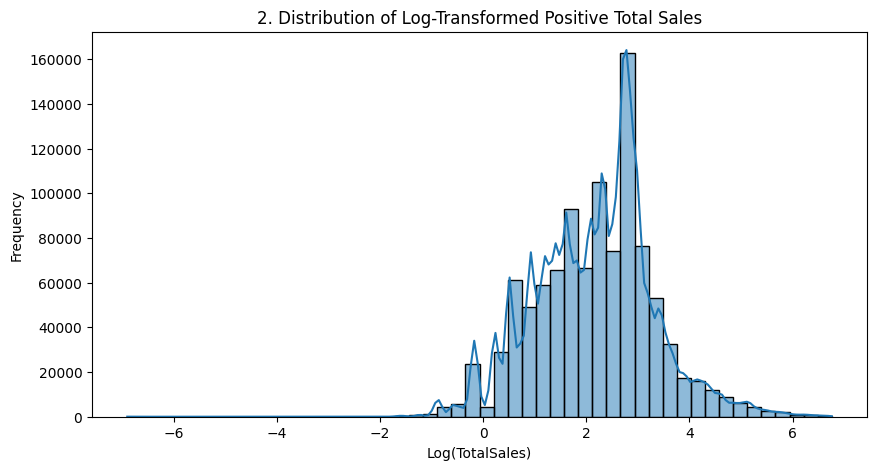

In [146]:
 #log transformed total sales
#2: Distribution of Log-Transformed Positive Total Sales ---
plt.figure(figsize=(10, 5))
sns.histplot(df_model['Log_TotalSales'], kde=True, bins=50)
plt.title('2. Distribution of Log-Transformed Positive Total Sales')
plt.xlabel('Log(TotalSales)')
plt.ylabel('Frequency')
plt.savefig('viz1_log_total_sales_distribution.png')
plt.show()

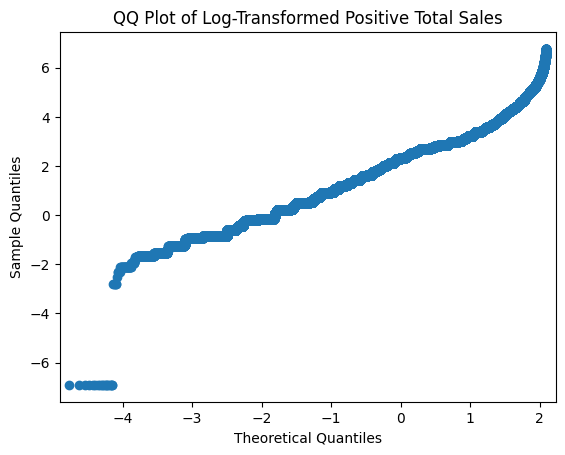

In [147]:
# QQ Plot for Log-Transformed TotalSales
import statsmodels.api as sm
from scipy import stats

sm.qqplot(df_model['Log_TotalSales'], line='s')
plt.title('QQ Plot of Log-Transformed Positive Total Sales')
plt.savefig('viz2_log_total_sales_qqplot.png')
plt.show()
plt.close()

In [148]:
product_quantity = df_model.groupby('Description')['Quantity'].sum().reset_index()
product_quantity.rename(columns={'Quantity': 'TotalQuantity'}, inplace=True)

#Select top 10 products by quantity
top_prod_df = product_quantity.nlargest(10, 'TotalQuantity').reset_index(drop=True)

#3: Top 10 Best-Selling Products by Quantity using tree map

treemap_fig = px.treemap(
    top_prod_df,
    path=['Description'],
    values='TotalQuantity',
    color='TotalQuantity',
    color_continuous_scale='Sunset',
    title="3. Top 10 Best-Selling Products by Total Quantity Sold (Treemap)",
    hover_data=['TotalQuantity']
)

treemap_fig.update_layout(
    title_x=0.5,
    margin = dict(t=50, l=25, r=25, b=25)
)
treemap_fig.show(config={'displaylogo': False})
# Save the figure as JSON
treemap_fig.write_json("viz17_top10_products_treemap.json")

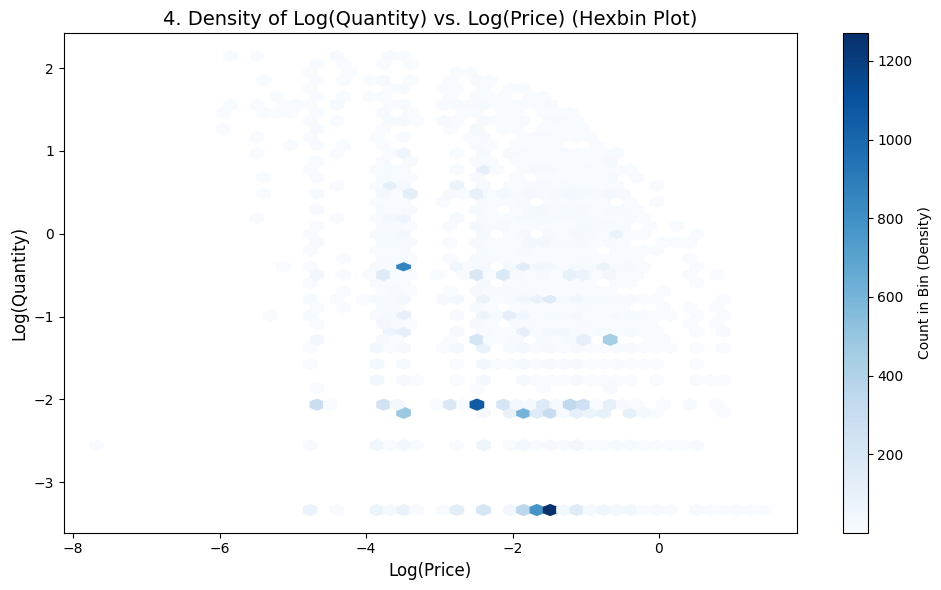

In [149]:
#4. Log tranfromation for Quantity and Price to see the relationship between both

df_model['Log_Quantity'] = np.log(df_model['Quantity'])
df_model['Log_Price'] = np.log(df_model['Price'])

plt.figure(figsize=(10, 6))
plt.hexbin(
    df_model['Log_Price'],
    df_model['Log_Quantity'],
    gridsize=50,
    cmap='Blues',
    mincnt=1
)

cb = plt.colorbar(label='Count in Bin (Density)')
plt.title('4. Density of Log(Quantity) vs. Log(Price) (Hexbin Plot)', fontsize=14)
plt.xlabel('Log(Price)', fontsize=12)
plt.ylabel('Log(Quantity)', fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig('viz19_log_quantity_vs_log_price_hexbin.png')
plt.close()

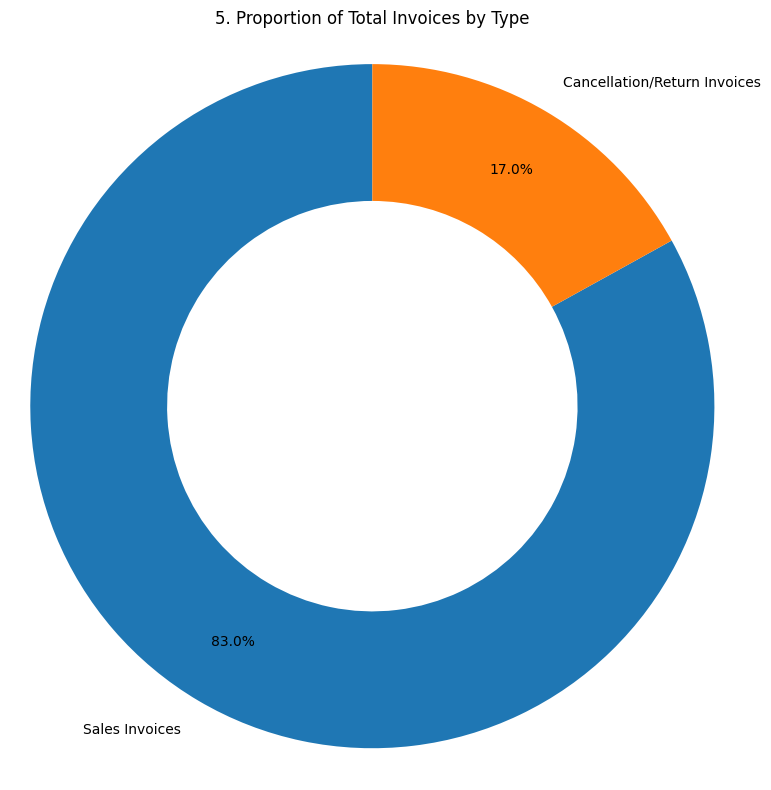

In [150]:
# 5. Proportion of Cancellations vs. Sales (Donut Chart)
total_invoices = df_model['Invoice'].nunique()
cancellation_invoices = df_model[df_model['IsCancelled'] == True]['Invoice'].nunique()
sales_invoices = total_invoices - cancellation_invoices
data = [sales_invoices, cancellation_invoices]
labels = ['Sales Invoices', 'Cancellation/Return Invoices']
plt.figure(figsize=(8, 8))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), pctdistance=0.8)
plt.title('5. Proportion of Total Invoices by Type')
plt.axis('equal')
plt.tight_layout()
plt.savefig('viz9_cancellation_vs_sales_proportion.png')
plt.show()
plt.close()

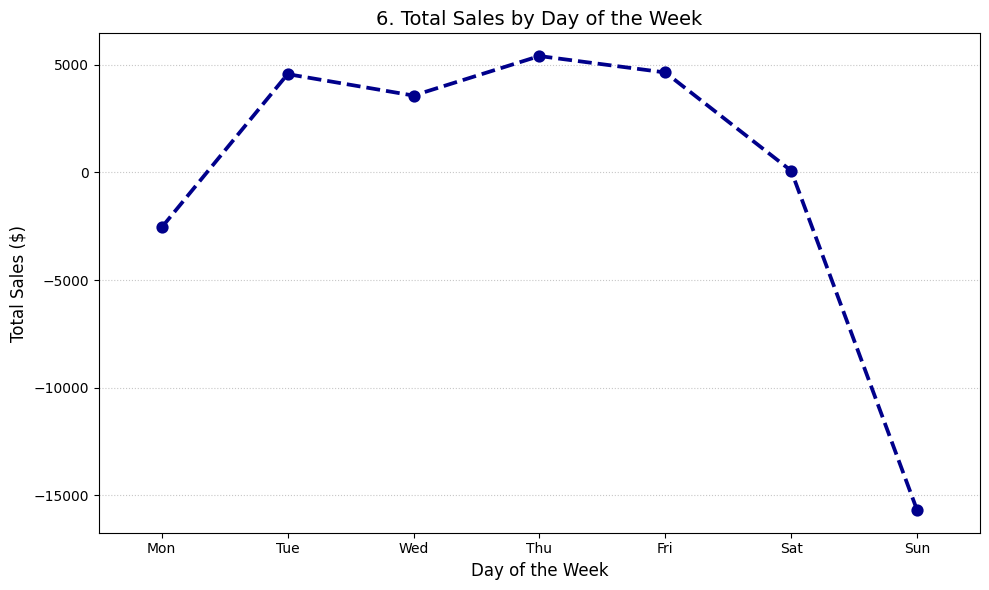

In [151]:
df_model['InvoiceDate'] = pd.to_datetime(df_model['InvoiceDate'], errors='coerce')

df_model['DayOfWeek'] = df_model['InvoiceDate'].dt.dayofweek
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_model['DayOfWeekName'] = df_model['DayOfWeek'].map(day_map)

#calc sales per day
sales_by_day = df_model.groupby('DayOfWeekName')['TotalSales'].sum().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']).reset_index()
sales_by_day.columns = ['DayOfWeekName', 'TotalSales']

# 6: Total Sales by Day of the Week using point plot

plt.figure(figsize=(10, 6))

sns.pointplot(
    x='DayOfWeekName',
    y='TotalSales',
    data=sales_by_day,
    color='darkblue',
    linestyles='--', #add dashed line
    markers='o'
)

plt.title('6. Total Sales by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(axis='y', alpha=0.7, linestyle=':')
plt.tight_layout()
plt.savefig('viz18_sales_by_day_of_week_pointplot.png')
plt.show()
plt.close()

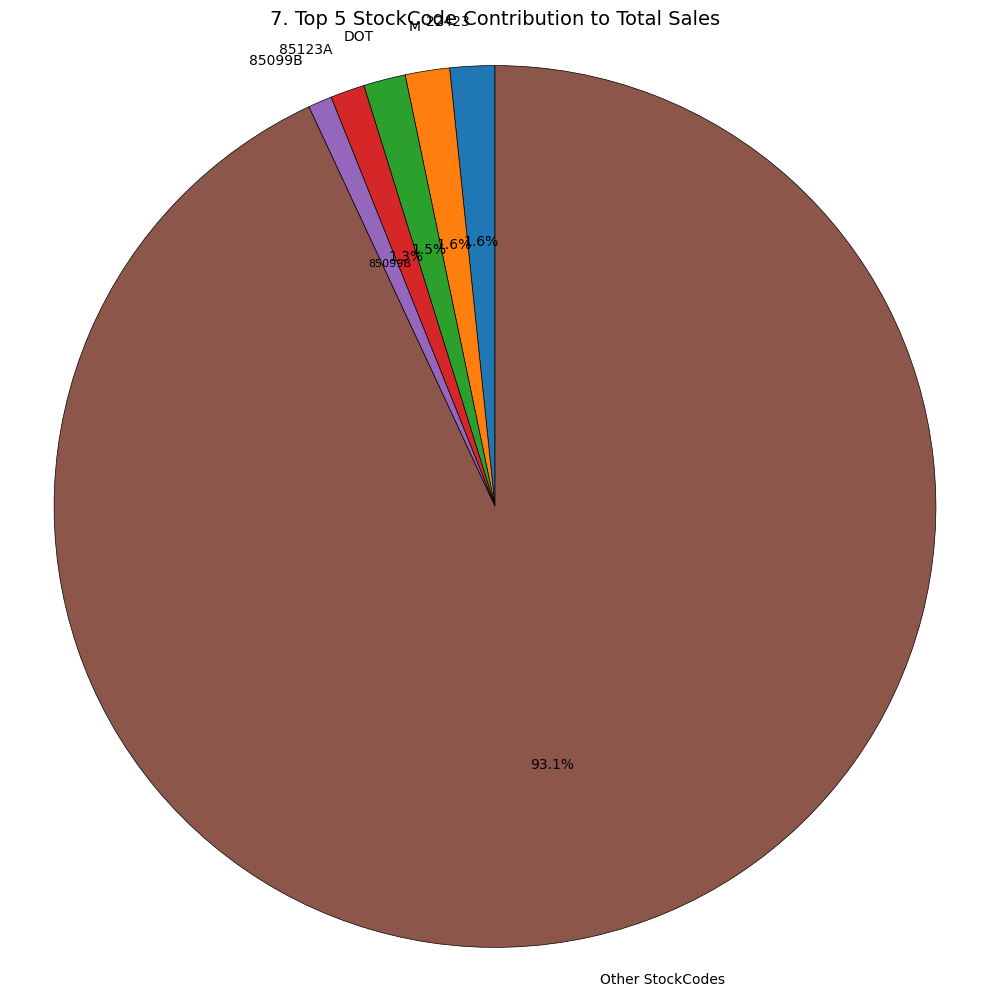

In [152]:
df_positive_sales = df_dedup[df_dedup['TotalSales'] > 0].copy()
calc_top_5_stock_codes = df_positive_sales.groupby('StockCode')['TotalSales'].sum().nlargest(5)
other_sales = df_positive_sales['TotalSales'].sum() - calc_top_5_stock_codes.sum()
sales_data = calc_top_5_stock_codes.to_list() + [other_sales]
labels = calc_top_5_stock_codes.index.to_list() + ['Other StockCodes']
percent = [f'{s/df_positive_sales["TotalSales"].sum()*100:.1f}%' for s in sales_data]
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(
    sales_data,
    labels=labels,
    autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '',
    startangle=90,
    textprops={'fontsize': 10},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
)
for i, text in enumerate(autotexts):
    if sales_data[i] / df_positive_sales['TotalSales'].sum() < 0.01:
        text.set_text(labels[i])
        text.set_fontsize(8)

plt.title('7. Top 5 StockCode Contribution to Total Sales', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.savefig('viz14_top5_stockcode_contribution_FIXED.png')
plt.show()
plt.close()

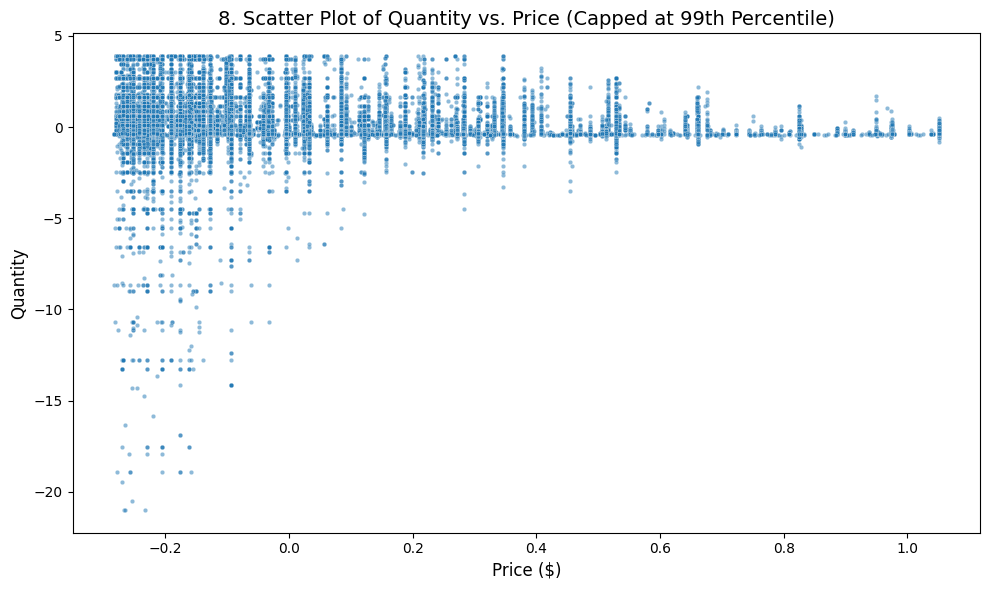

In [153]:
# 8. Scatter Plot of Quantity vs. Price
qty_cap = df_model['Quantity'].quantile(0.99)
price_cap_scatter = df_model['Price'].quantile(0.99)
df_scatter = df_model[(df_model['Quantity'] <= qty_cap) & (df_model['Price'] <= price_cap_scatter)].copy()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Quantity', data=df_scatter, alpha=0.5, s=10)
plt.title('8. Scatter Plot of Quantity vs. Price (Capped at 99th Percentile)', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.tight_layout()
plt.savefig('viz15_qty_vs_price_scatter_capped.png')
plt.show()
plt.close()

In [154]:
total_quantity_sold = df_model['Quantity'].sum()

product_quantity = df_model.groupby(['StockCode', 'Description'])['Quantity'].sum().reset_index()
product_quantity.rename(columns={'Quantity': 'TotalQuantity'}, inplace=True)

product_quantity['Percentage'] = (product_quantity['TotalQuantity'] / total_quantity_sold) * 100

# Select top 10 products by percentage
top_products_df = product_quantity.nlargest(10, 'Percentage').reset_index(drop=True)

#9: Individual product quantity percentage

bar_fig = px.bar(top_products_df,
                 x="StockCode",
                 y="Percentage",
                 color="Description",
                 title="16. Individual Product Quantity Percentage (Top 10)",
                 labels={"Percentage": "Quantity Percentage (%)", "StockCode": "Stock Code"},
                 hover_data=['Description', 'TotalQuantity']
                )

bar_fig.update_layout(title_x=0.5, title_y=0.8,
                      legend_title="Description",
                      legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                      uniformtext_minsize=8,
                      uniformtext_mode='hide'
                     )

bar_fig.show(config={'displaylogo': False})

<a id='rfm_analysis'></a>
# RFM Analysis

In this section we will see some analysis of customers ans bacis RFM analysis.
RFM analysis: is a marketing technique used to quantitatively rank and group customers based on the `recency, frequency and monetary` total of their recent transactions to `identify the best customers and perform targeted marketing campaigns`.


## Top Customers
Calculate how often did particular customer make purchase during the year

In [155]:
df_data = df_model

In [156]:
df_data.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)
df_data.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,IsCancelled,Log_TotalSales,Log_Price,Log_Quantity,InvoiceYearMonth,Revenue,DayOfWeek,DayOfWeekName
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.136177,2010-12-01 08:26:00,-0.094405,17850.0,United Kingdom,-0.048204,False,2.727853,NaN,NaN,201012,0.012856,2,Wed
1,1,536365,71053,WHITE METAL LANTERN,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,NaN,NaN,201012,0.004378,2,Wed
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.050290,2010-12-01 08:26:00,-0.079582,17850.0,United Kingdom,0.121034,False,3.091042,NaN,NaN,201012,0.004002,2,Wed
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,NaN,NaN,201012,0.004378,2,Wed
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,NaN,NaN,201012,0.004378,2,Wed


In [157]:
df_data['freq'] = df_data.groupby('CustomerID')['CustomerID'].transform('count')

In [158]:
# Calculate the top 500 customers who brings the highest revenue
customer  = pd.DataFrame(df_data.groupby(['CustomerID'])['Revenue'].sum().sort_values(ascending=False)).reset_index().head(10)

In [159]:
customer['CustomerID'].tolist()

[17841.0,
 16549.0,
 14606.0,
 14159.0,
 18283.0,
 13263.0,
 18118.0,
 15719.0,
 13137.0,
 15005.0]

In [160]:
top_customer = df_data[df_data['CustomerID'].isin(customer['CustomerID'].tolist())][['CustomerID', 'Country', 'Revenue', 'Quantity', 'freq']]

In [161]:
# Countries where the top customers resids
top_customer['Country'].unique().tolist()

['United Kingdom']

In [162]:
df_rfm = df_data
df_rfm.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,IsCancelled,Log_TotalSales,Log_Price,Log_Quantity,InvoiceYearMonth,Revenue,DayOfWeek,DayOfWeekName,freq
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.136177,2010-12-01 08:26:00,-0.094405,17850.0,United Kingdom,-0.048204,False,2.727853,NaN,NaN,201012,0.012856,2,Wed,2827.0
1,1,536365,71053,WHITE METAL LANTERN,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,NaN,NaN,201012,0.004378,2,Wed,2827.0
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.050290,2010-12-01 08:26:00,-0.079582,17850.0,United Kingdom,0.121034,False,3.091042,NaN,NaN,201012,0.004002,2,Wed,2827.0
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,NaN,NaN,201012,0.004378,2,Wed,2827.0
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.136177,2010-12-01 08:26:00,-0.032146,17850.0,United Kingdom,0.079103,False,3.012589,NaN,NaN,201012,0.004378,2,Wed,2827.0


In [163]:
print(df_rfm['InvoiceDate'].min())
print(df_rfm['InvoiceDate'].max())

2009-12-01 07:45:00
2011-12-09 12:50:00


In [164]:
import datetime as dt
presence = dt.datetime(2011,12,10)
df_rfm['InvoiceDate'] = pd.to_datetime(df_rfm['InvoiceDate'])

# Calculate recency, frequency and monetary values:

`Recency (R) as days since last purchase`: How many days ago was their last purchase? Deduct most recent purchase date from today to calculate the recency value. 1 day ago? 14 days ago? 500 days ago?

`Frequency (F) as total number of transactions`: How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10.

`Monetary (M) as total money spent`: How many $$ (or whatever is your currency of calculation) has this customer spent? Again limit to last two years – or take all time. Simply total up the money from all transactions to get the M value.

In [165]:
rfm = df_rfm.groupby('CustomerID').agg({'InvoiceDate': lambda x: (presence - x.max()).days, 'InvoiceNo': lambda x: len(x), 'Revenue': lambda x: x.sum()})
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)
rfm.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'Revenue': 'monetary_value'}, inplace=True)

In [166]:
rfm.head()


,recency,frequency,monetary_value
CustomerID,,,
12346.0,431,46,-12.586960
12347.0,2,253,-12.626348
12348.0,75,51,-26.547324
12349.0,18,180,-29.513544
12350.0,310,17,-1.341884


In [167]:
# Define quartiles for rfm score:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [168]:
rfm_segments= rfm


In [169]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [170]:
rfm_segments['R_Quartile'] = rfm_segments['recency'].apply(RClass, args=('recency',quantiles,))
rfm_segments['F_Quartile'] = rfm_segments['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfm_segments['M_Quartile'] = rfm_segments['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [171]:
rfm_segments['RFMClass'] = rfm_segments.R_Quartile.map(str) \
                            + rfm_segments.F_Quartile.map(str) \
                            + rfm_segments.M_Quartile.map(str)

In [172]:
rfm_segments.head()


,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerID,,,,,,,
12346.0,431,46,-12.586960,4,3,4,434
12347.0,2,253,-12.626348,1,1,4,114
12348.0,75,51,-26.547324,2,3,4,234
12349.0,18,180,-29.513544,1,1,4,114
12350.0,310,17,-1.341884,3,4,2,342


In [173]:
rfm_segments['RFMClass'].unique()


array(['434', '114', '234', '342', '224', '332', '323', '333', '124',
       '214', '123', '334', '443', '142', '442', '424', '213', '233',
       '143', '314', '223', '324', '322', '343', '432', '113', '422',
       '441', '242', '431', '433', '132', '232', '133', '414', '134',
       '331', '221', '231', '211', '243', '423', '341', '131', '321',
       '141', '212', '222', '122', '313', '421', '344', '241', '413',
       '111', '311', '121', '411', '412', '112', '244', '444', '144',
       '312'], dtype=object)

In [174]:
print("Champions: ",len(rfm_segments[rfm_segments['RFMClass']=='111']), "(", round(len(rfm_segments[rfm_segments['RFMClass']=='111'])/len(rfm_segments)*100,2), "%)")
print('Loyal Customers: ',len(rfm_segments[rfm_segments['F_Quartile']==1]), "(", round(len(rfm_segments[rfm_segments['F_Quartile']==1])/len(rfm_segments)*100,2), "%)")
print("Big Spenders: ",len(rfm_segments[rfm_segments['M_Quartile']==1]), "(", round(len(rfm_segments[rfm_segments['M_Quartile']==1])/len(rfm_segments)*100,2), "%)")
print('About to Sleep: ', len(rfm_segments[rfm_segments['RFMClass']=='322']), "(", round(len(rfm_segments[rfm_segments['RFMClass']=='322'])/len(rfm_segments)*100,2), "%)")
print('Lost Customers: ',len(rfm_segments[rfm_segments['RFMClass']=='444']), "(", round(len(rfm_segments[rfm_segments['RFMClass']=='444'])/len(rfm_segments)*100,2), "%)")

Champions:  188 ( 3.18 %)
Loyal Customers:  1474 ( 24.94 %)
Big Spenders:  1478 ( 25.0 %)
About to Sleep:  46 ( 0.78 %)
Lost Customers:  33 ( 0.56 %)


Form the above calculations we can say that there are total `24.84% of loyal customers` and `25.01% of big spenders`.